The following is adapted from [this example](https://github.com/ColmTalbot/wcosmo/blob/main/examples/wcosmo_gwtc3.ipynb) in `wcosmo`.

## Download the data

In [ ]:
!pip install gdown

In [ ]:
!gdown https://drive.google.com/uc?id=16gStLIjt65gWBkw-gNOVUqNbZ89q8CLF
!gdown https://drive.google.com/uc?id=10pevUCM3V2-D-bROFEMAcTJsX_9RzeM6

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from corner import corner
from tqdm import tqdm
import pandas
import dill

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import jax
jax.config.update('jax_enable_x64', True)
import jax.numpy as jnp

import gwpopulation
from gwpopulation.models.mass import two_component_primary_mass_ratio
from gwpopulation.models.redshift import PowerLawRedshift
from gwpopulation.models.spin import iid_spin
from gwpopulation.vt import ResamplingVT
from gwpopulation.hyperpe import HyperparameterLikelihood
from gwpopulation.experimental.cosmo_models import CosmoModel
from gwpopulation.experimental.jax import JittedLikelihood
from wcosmo.astropy import Planck15
from wcosmo.utils import disable_units

disable_units()
gwpopulation.set_backend('jax')

In [2]:
import optax

from gwax.variational import trainer

## Load data

In [3]:
posteriors = pandas.read_pickle("gwtc-3-samples.pkl")
del posteriors[15]
del posteriors[38]

for post in tqdm(posteriors):
    zs = post.pop("redshift").values
    post["mass_1_detector"] = post.pop("mass_1") * (1 + zs)
    post["luminosity_distance"] = np.asarray(Planck15.luminosity_distance(zs))
    post["prior"] /= np.asarray(Planck15.dDLdz(zs) * (1 + zs))

100%|██████████████████████████████████████████████████████████████████████████████| 71/71 [00:33<00:00,  2.14it/s]


In [4]:
with open("gwtc-3-injections.pkl", "rb") as ff:
    injections = dill.load(ff)

zs = np.asarray(injections.pop("redshift"))
injections["mass_1_detector"] = injections.pop("mass_1") * (1 + zs)
injections["luminosity_distance"] = np.asarray(Planck15.luminosity_distance(zs))
injections["prior"] /= np.asarray(Planck15.dDLdz(zs) * (1 + zs))

for key in injections:
    injections[key] = jnp.asarray(injections[key])

## Define the likelihood

In [5]:
def mass_model(dataset, alpha, beta, mmin, mmax, lam, mpp, sigpp):
    gaussian_mass_maximum = 100
    return two_component_primary_mass_ratio(
        dataset,
        alpha, beta, mmin, mmax, lam, mpp, sigpp,
        gaussian_mass_maximum = gaussian_mass_maximum,
    )

def make_model():
    return CosmoModel(
        model_functions = [
            mass_model,
            PowerLawRedshift(cosmo_model = 'FlatLambdaCDM'),
        ],
        cosmo_model = 'FlatLambdaCDM',
    )

In [6]:
selection_function = ResamplingVT(
    model = make_model(),
    data = injections,
    n_events = len(posteriors),
    marginalize_uncertainty = False,
    enforce_convergence = False,
)

likelihood = HyperparameterLikelihood(
    posteriors = posteriors,
    hyper_prior = make_model(),
    selection_function = selection_function,
)

## Define the prior

Only uniform prior is supported at the moment (but this will be easy to extend).

In [7]:
prior_bounds = dict(
    alpha = [-2, 4],
    beta = [-4, 12],
    mmin = [2, 2.5],
    mmax = [80, 100],
    lam = [0, 1],
    mpp = [10, 50],
    sigpp = [1, 10],
    lamb = [-1, 10],
    H0 = [20, 200],
    Om0 = [0, 1],
)

In [23]:
prior_bounds

{'alpha': [-2, 4],
 'beta': [-4, 12],
 'mmin': [2, 2.5],
 'mmax': [80, 100],
 'lam': [0, 1],
 'mpp': [10, 50],
 'sigpp': [1, 10],
 'lamb': [-1, 10],
 'H0': [20, 200],
 'Om0': [0, 1]}

## Train a flow to learn the prior

In [8]:
steps = 1_000
learning_rate = 1e-0
learning_rate = optax.cosine_decay_schedule(learning_rate, steps)
optimizer = optax.adam(learning_rate)

In [9]:
flow_prior, losses = trainer(
    key = jax.random.key(0),
    prior_bounds = prior_bounds,
    likelihood = None,
    batch_size = 10_000,
    steps = steps,
    optimizer = optimizer,
)

GWAX: Getting ready...


GWAX: Variational training:   0%|          | 0/1001 [00:00<?, ?it/s]

GWAX: Total time = 7.520580768585205 s


(-0.1, 1.0)

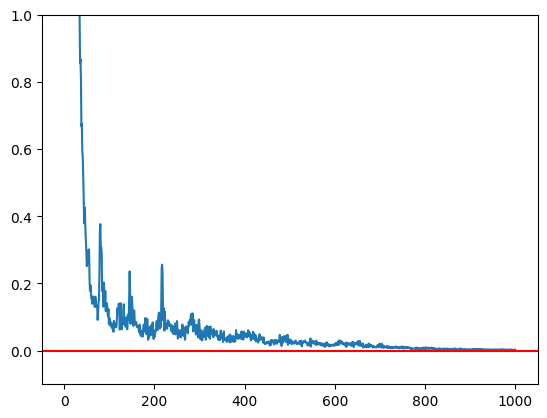

In [10]:
plt.plot(losses)
plt.axhline(0, c = 'r')
plt.ylim(-0.1, 1)

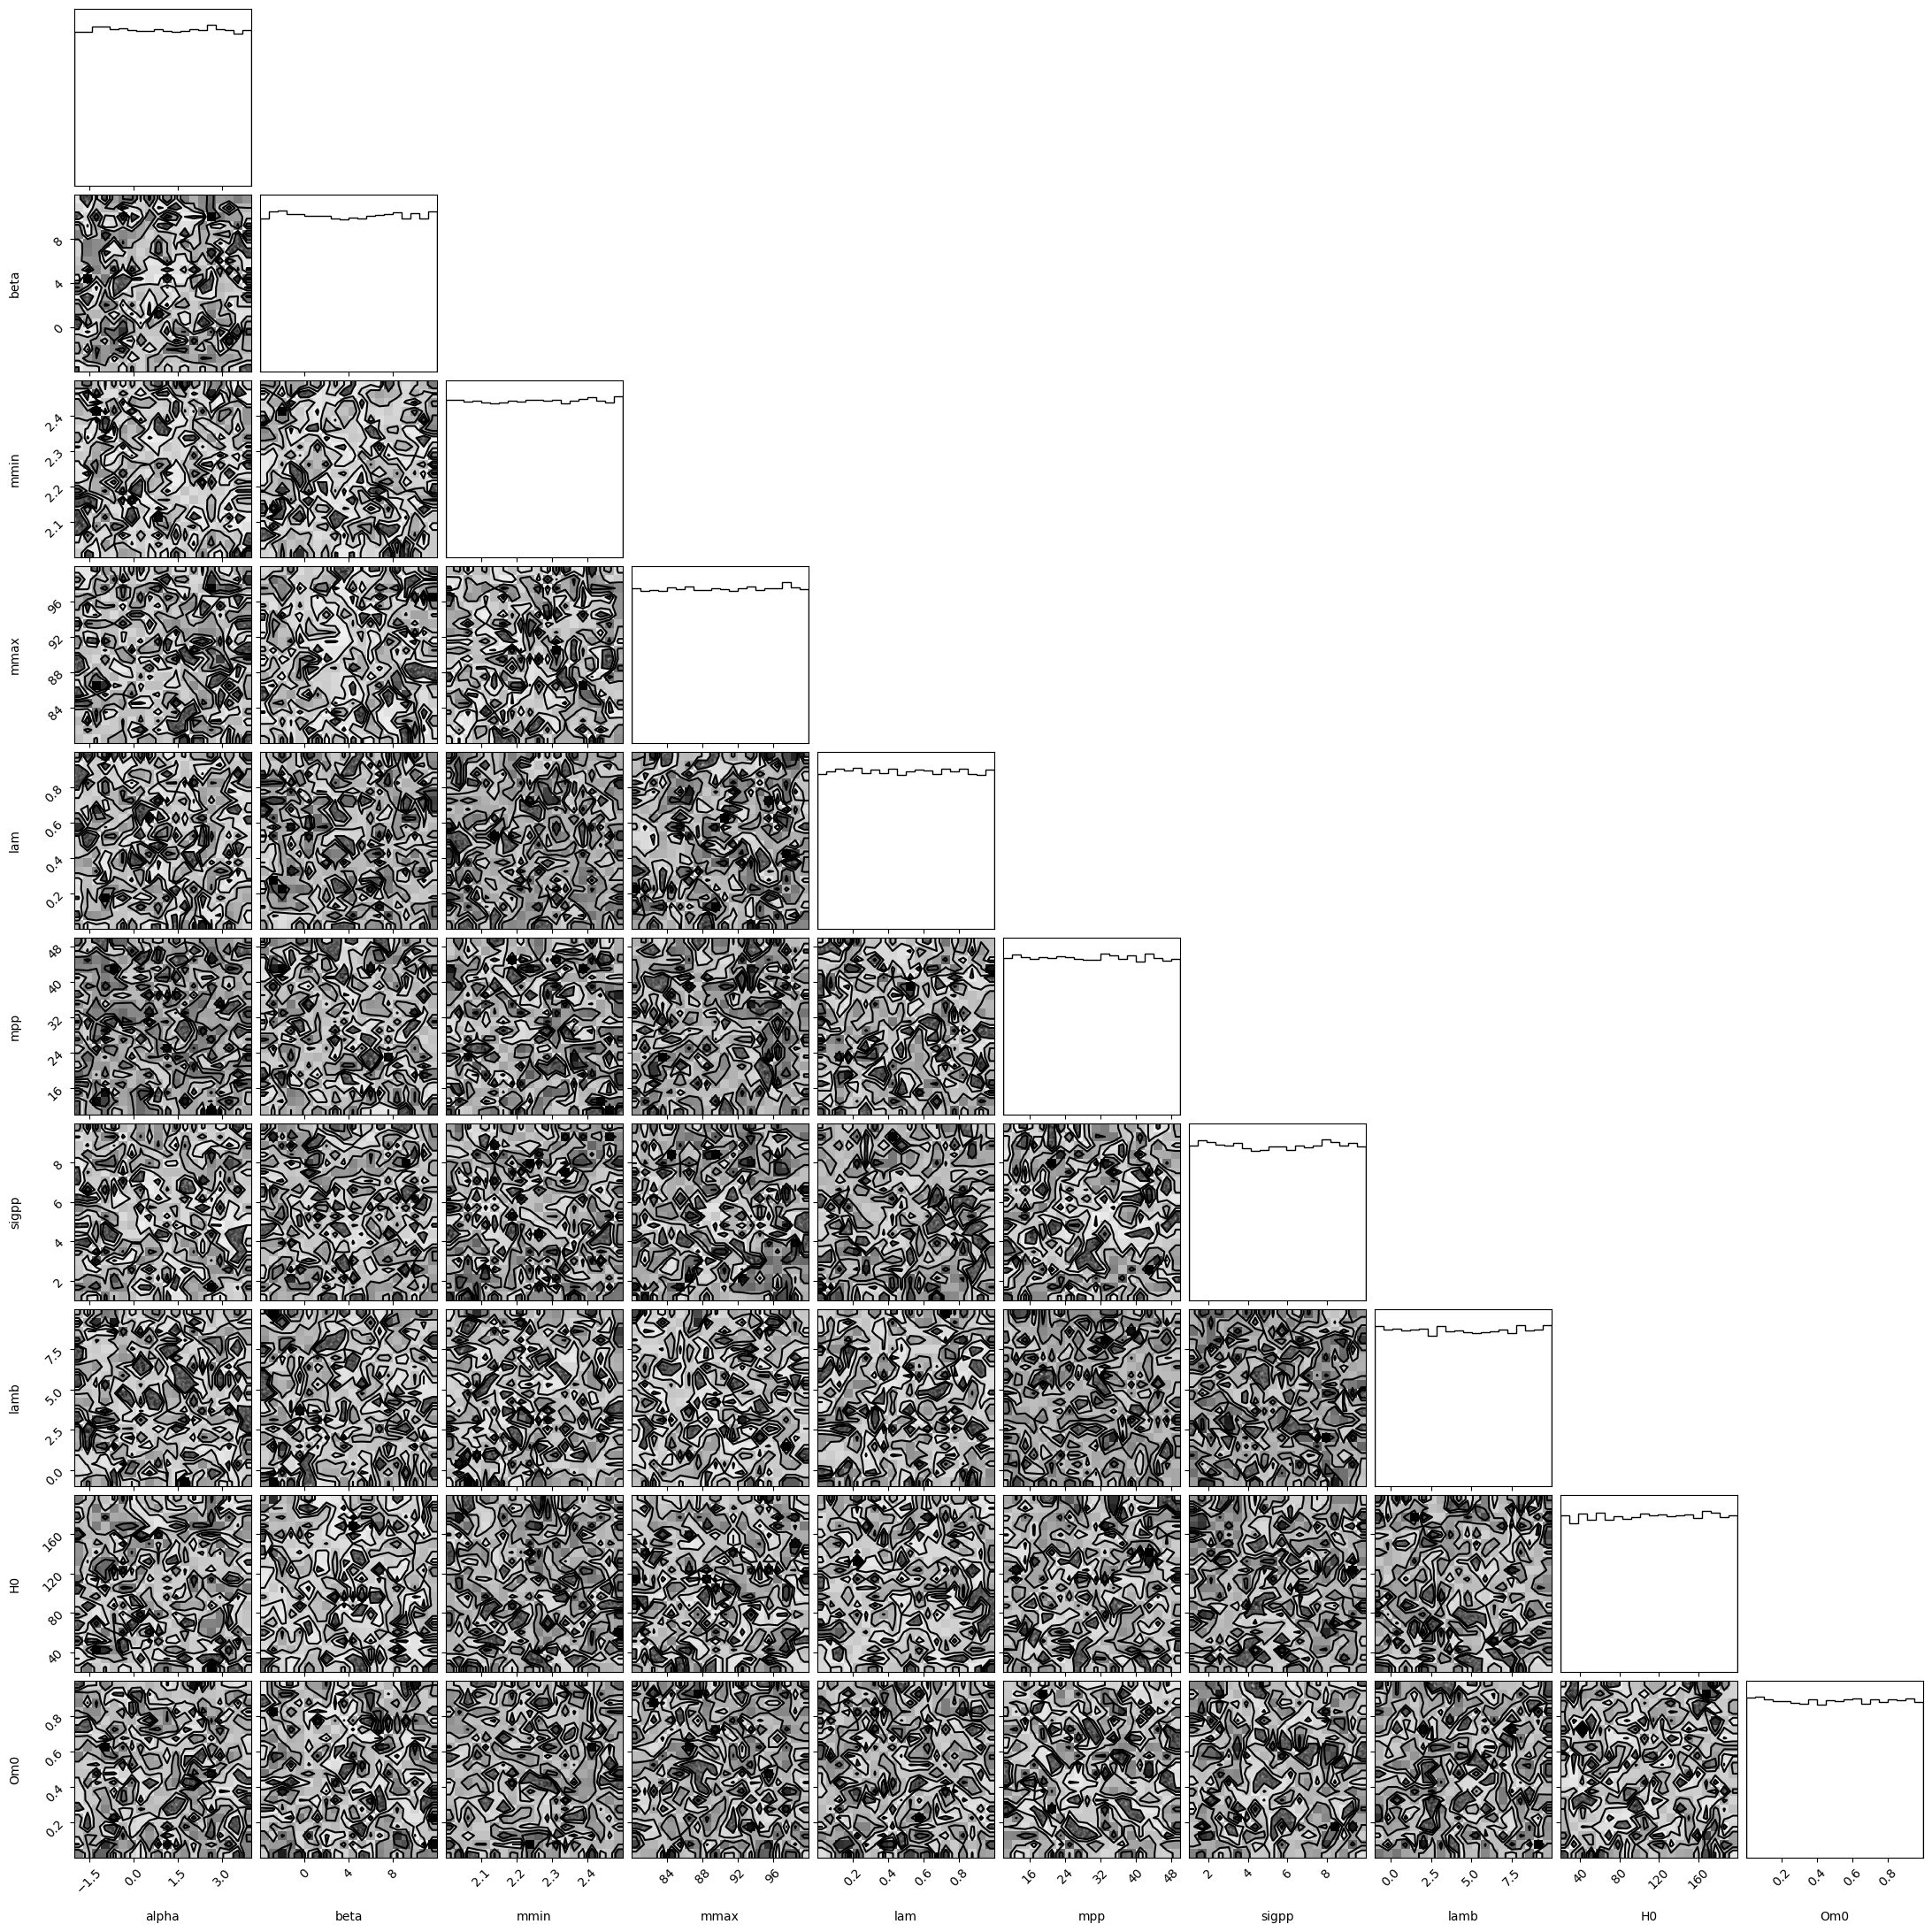

In [11]:
samples = flow_prior.sample(jax.random.key(1), (100_000,))
corner(np.array(samples), labels = list(prior_bounds));

## Train a flow to learn the posterior

In [18]:
# differentiable taper to avoid high Monte Carlo uncertainty
max_variance = 1.0
taper = lambda variance: jax.nn.log_sigmoid(100 * (max_variance - variance))

In [19]:
steps = 1_000
learning_rate = 1e-1
learning_rate = optax.cosine_decay_schedule(learning_rate, steps)
optimizer = optax.adam(learning_rate)
optimizer = optax.chain(optax.clip_by_global_norm(1.0), optimizer)

In [20]:
flow, losses = trainer(
    key = jax.random.key(2),
    prior_bounds = prior_bounds,
    likelihood = likelihood,
    flow = flow_prior,
    batch_size = 1,
    steps = steps,
    optimizer = optimizer,
    taper = taper,
)

GWAX: Getting ready...


GWAX: Variational training:   0%|          | 0/1001 [00:00<?, ?it/s]

GWAX: Total time = 399.4275116920471 s


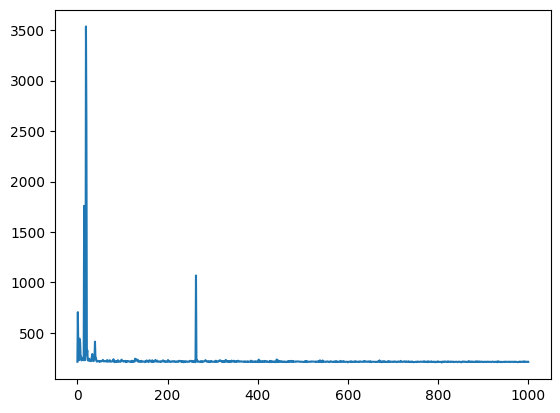

In [21]:
plt.plot(losses);

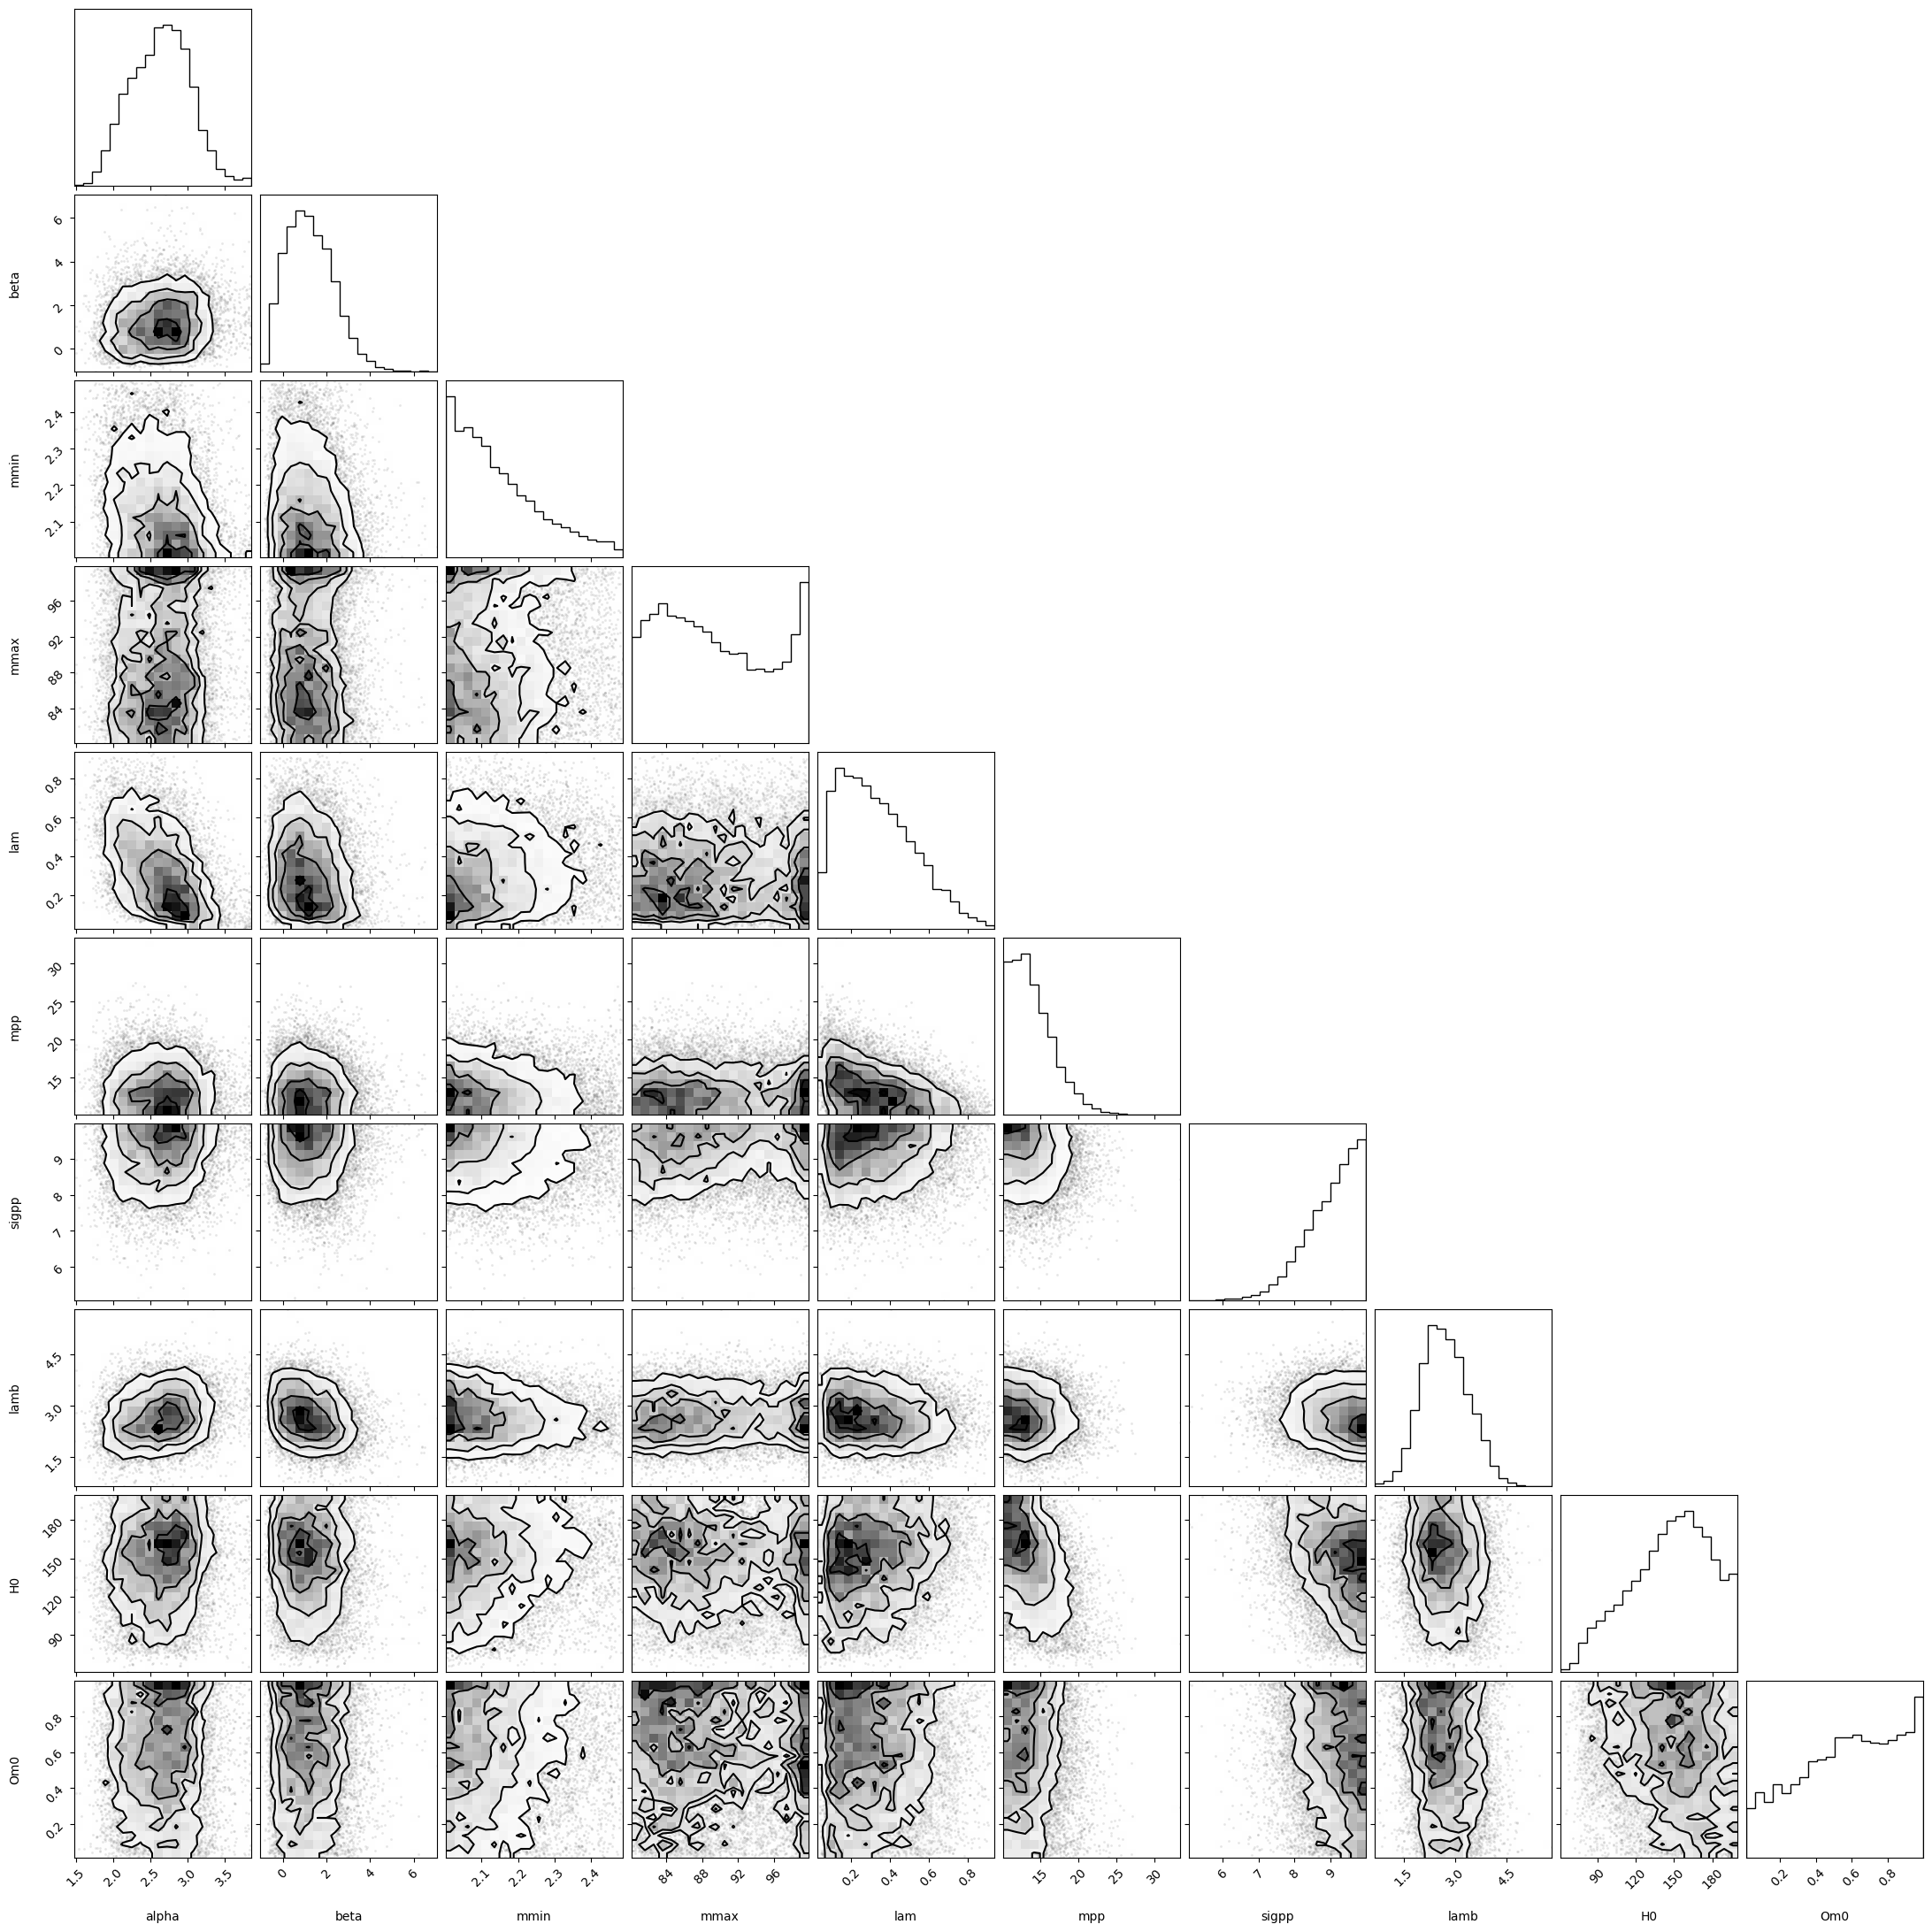

In [22]:
samples = flow.sample(jax.random.key(3), (10_000,))
corner(np.array(samples), labels = list(prior_bounds));